In [1]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

env = gym.make('FrozenLake-v0')  # 이미 만들어져 있음 : 'is_slippery': True

def one_hot(x):
    return np.identity(16)[x:x+1]


[2017-02-13 20:33:34,830] Making new env: FrozenLake-v0


In [2]:
# Input and output size based on the Env
input_size = env.observation_space.n
output_size = env.action_space.n
learining_rate = 0.1

In [3]:
# These lines establish the feed-forward part of the network used to choose actions
X = tf.placeholder(shape=[1,input_size],dtype=tf.float32) # state input
W = tf.Variable(tf.random_uniform([input_size, output_size],0,0.01)) # weight

In [4]:
Qpred = tf.matmul(X, W) # Out Q prediction
Y = tf.placeholder(shape=[1, output_size],dtype=tf.float32) # Y label

In [5]:
loss = tf.reduce_sum(tf.square(Y - Qpred))

In [6]:
train = tf.train.GradientDescentOptimizer(learning_rate=learining_rate).minimize(loss)

In [7]:
# Set Q-learning related parameters
dis = .99
num_episodes = 2000

In [8]:
# Create lists to contain total rewards and steps per episode
rList = []

In [9]:
init = tf.global_variables_initializer()

In [10]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environment and get first new observation
        s = env.reset()
        e = 1. / ((i / 50) + 10)
        rAll = 0
        done = False
        local_loss = []
        
        # The Q-Network training
        while not done:
            # Choose and action by greedily (with a chance of random action) from the Q-network
            Qs = sess.run(Qpred,feed_dict={X: one_hot(s)})
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)
                
            # Get new state and reward from environment 
            s1, reward, done, _ = env.step(a)
            if done:
                # Update Q, and no Qs+1, since it's a terminal state
                Qs[0, a] = reward
            else:
                # Obtain the Q_s1 values by feeding the new state through our network
                Qs1 = sess.run(Qpred, feed_dict={X: one_hot(s1)})
                # Update Q
                Qs[0, a] = reward + dis * np.max(Qs1)
                
            # Train our network using target (Y) and predicted Q (Qpred) values
            sess.run(train, feed_dict={X: one_hot(s), Y: Qs})
            
            rAll += reward
            s = s1
        rList.append(rAll)

Percent of successful episodes: 0.4835%


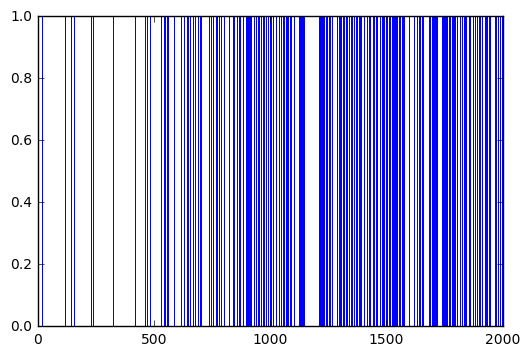

In [11]:
print("Percent of successful episodes: " + str(sum(rList) / num_episodes) + "%")

#plt.bar(range(len(rList)), rList, color="blue")   # blue가 안먹네. (윈7) : edgecolor가 검은색
#plt.bar(range(len(rList)), rList, color="blue", edgecolor="none")    # edgecolor를 none으로 하면 color가 나옴
plt.bar(range(len(rList)), rList, color="blue", linewidth=0)    # edgecolor를 none으로 하면 color가 나옴
plt.show()